# Lecture 2: Dynamic Transition Path
* All model features are the same as in the model from the exercise in Lecture 1.
* We now consider the transition between two steady states before and after the introduction of a pension scheme.
* We model this as an MIT shock (a shock in a world without shocks) to the pension contribution rate $\tau$ at time $t$.


## Solution Algorithm
The decision problem of the individual is forward looking, as agents take into account expected future factor prices and benefits $T$ periods ahead. However, as generations overlap, cohort-specific decisions are interdependent, and thus, the dynamic transition path becomes infinitely forward looking.

* This poses a challenge when solving such models for a dynamic transition numerically!

To tackle this challenge, we utilize an Auerbach-Kotlikoff-type algorithm that uses information on the long-run steady-state equilibrium to truncate the problem at a finite time horizon. In any period after this finite horizon, the economy is assumed to have converged to the new steady state, such that all future prices are known. To initialize the algorithm, we assume that the economy is initially in a steady state with $\tau=0$ and has been for many periods. Thus, we know the level of inherited capital when the shock occurs.

Formally,

1. Guess a transition path vector of capital from one steady state to the other. For all period on the finite transition path, $t_p\in TP$.
    1. The first $T$ entries of the vector are equal to the pre-shock, steady-state capital level, while the last $T$ entries are equal to the post-shock, steady-state capital level.
2. Calculate associated vectors of factor prices and pension benefits.
3. For cohorts born before the shock, $t_p<t$, update savings decisions given past savings and future prices.
4. Loop over the periods after the shock and
    1. use inherited savings to produce a new guess for capital, factor prices and pennsion benefits in the loop period.
    2. for cohorts born after the shock, $t_p\geq t$, compute new savings decisions in the loop period given future prices.
5. Check whether the updated transition path vector of capital is equal to the intitial vector.
6. Given the updated transition path,  **repeat step 3 to 5** until the entire path converges.


## Adjustment
In step 3 of the solution algorithm, we allow people born before the shock (alive at the time of the shock), to update their planned behavior given the old steady state.

Imagine that new information arrives at the start of period $t$. Then an individual who is aged $j$ in that period was born in period $t-j$ and now solves:
\begin{align}
\max_{\left\{c_{\tau,t-j},a_{\tau,t-j}\right\} }\text{ }U_{t-j} & =\sum_{x=j}^{d}\beta^{x}u\left(c_{x,t-j}\right)\\
& s.t.\\
c_{x,t-j}+a_{x,t-j} & =\left(1-\tau_{t-j+x}\right)w_{t-j+x}l_{x,t-j}+\left(1 + r_{t-j+x}\right)a_{x-1,t-j}+b_{t-j+x}\left(1-l_{x,t-j}\right)
\end{align}
for $x\geq a$ given savings, $a_{j-1,t-j}$, carried over from the previous period. The consolidated budget reads:
\begin{align}
    \sum_{x=j}^{d}\dfrac{c_{x,t-j}}{\prod_{s=j}^{x}\left(1 + r_{t-j+s}\right)} & =a_{j-1,t-j}+\sum_{x=j}^{d}\dfrac{\left(1-\tau_{t-j+x}\right)w_{t-j+x}l_{x,t-j}+b_{t-j+x}\left(1-l_{x,t-j}\right)}{\prod_{s=j}^{x}\left(1 + r_{t-j+s}\right)}
\end{align}

The long-run Euler equation at age $x$ can be written as:
\begin{align}
    c_{x,t-j} & =\left(\beta^{x-j}\dfrac{\prod_{s=j}^{x}\left(1 + r_{t-j+s}\right)}{1+r_{t}}\right)^{\frac{1}{\sigma}}c_{j,t-j}
    \tag{L2.1}
\end{align}

Thus, we can solve closed-form for consumption in the period of the shock:
\begin{equation*}
    c_{a,t-j}=\dfrac{a_{j-1,t-j}+\sum_{x=j}^{d}\dfrac{\left(1-\tau_{t-j+\tau}\right)w_{t-j+\tau}l_{\tau,t-j}+b_{t-j+\tau}\left(1-l_{\tau,t-j}\right)}{\prod_{s=j}^{x}\left(1 + r_{t-j+s}\right)}}{\sum_{\tau=a}^{d}\dfrac{\left(\beta^{\tau-j}\dfrac{\prod_{s=j}^{\tau}\left(1 + r_{t-j+s}\right)}{1 + r_{t}}\right)^{\frac{1}{\sigma}}}{\prod_{s=j}^{\tau}\left(1 + r_{t-j+s}\right)}}
    \tag{L2.2}
\end{equation*}

## Implementation

In [1]:
# Import packages
import numpy as np
import scipy.optimize as optimize
import time
import SS_Functions as SS
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

### Functions

In [5]:
def savings_function(rvec,wvec,bvec,τ,par): # Solve for consumption, savings and aggregate capital given a guess for r 
    # "rvec" is a vector of interest rates
    # "wvec" is a vector of the wage rates
    # "bvec" is a vector of the pension benefits
    # "τ" is as scalar of the pension contribution rate
    # "par" contains the parameters
    
   # Unpacking Parameters
    T = par['T']
    ρ = par['ρ']
    β = par['β']
    l = par['l']
    
    # Solve for first-period consumption as in equation (L1.3)
    c1_numerator =   sum(((1-τ)*wvec*l + (1-l)*bvec)/np.cumprod(1+rvec))
    c1_denominator = sum(((np.cumprod(1+rvec)*β**np.arange(T))/(1+rvec[0]))**(1/ρ)/np.cumprod(1+rvec))
    C1 = c1_numerator/c1_denominator
    
    # Solve for the whole consumption path using the long-term Euler-Equation in (L1.2)
    C = C1*(β**np.arange(T)*np.cumprod(1+rvec)/(1+rvec[0]))**(1/ρ)

    # STEP 5: Solve for the whole saviongs path using the budget constraint
    A = np.zeros(T) # preallocate storage
    
    A[0] = (1-τ)*wvec[0]*l[0] - C[0] # solve for first period savings given no initial wealth
    
    for t in range(T): # solve the whole savings path
        if t>0:
            A[t] = (1-τ)*wvec[t]*l[t] + (1-l[t])*bvec[t] + (1 + rvec[t])*A[t-1] - C[t]
                  
    return A,C


def update_savings(age,A,C,rvec,wvec,bvec,τ,par): # Solve for consumption, savings and aggregate capital given a guess for r 
    # "age" is the age in the shock period
    # "A" is the pre-shock savings-path
    # "C" is the pre-shock consumption-path
    # "rvec" is a vector of interest rates
    # "wvec" is a vector of the wage rates
    # "bvec" is a vector of the pension benefits
    # "τ" is as scalar of the pension contribution rate
    # "par" contains the parameters
    
   # Unpacking Parameters
    T = par['T']
    ρ = par['ρ']
    β = par['β']
    l = par['l']
    
    # Determine savings from the period just before the shock
    if age==0:
        A_init = 0 # New generations do not have initial wealth (a sanity check)
    else:
        A_init = A[age-1] # Generations who were born before the shock
    
    # Solve for shock-period consumption as in L2.2
    numerator   =  A_init + sum(((1-τ)*wvec[age:T]*l[age:T] + (1-l[age:T])*bvec[age:T])/np.cumprod(1+rvec[age:T]))
    denominator =  sum((β**np.arange(T-age)*np.cumprod(1+rvec[age:T])/(1+rvec[age]))**(1/ρ)/np.cumprod(1+rvec[age:T]))
    C_age = numerator/denominator
    
    # Solve for the whole consumption path using L2.1
    C[age:T] = C_age*(β**np.arange(T-age)*np.cumprod(1+rvec[age:T])/(1+rvec[age]))**(1/ρ)
    
    # Update savings using the period-by-period budget
    if age==0:
        # solve for first period savings given no initial wealth
        A[age] = (1-τ)*wvec[age]*l[age] + (1-l[age])*bvec[age] - C[age]
    
    # solve the whole savings path
    for x in range(age,T,1):
        if x>0:
            A[x] = (1-τ)*wvec[x]*l[x] + (1-l[x])*bvec[x] + (1 + rvec[x])*A[x-1] - C[x]
    
    return A,C

## Calibration

In [6]:
# Define a dictionary for model parameters
par = dict() 
# Calibrate parameters
par['T'] = 20 # max age
par['R'] = 15 # retirement age
par['α'] = 1/3 # output elasticities of capital
par['ρ'] = 2 # risk aversion parameter
par['δ'] = 0.07 # yearly discount rate
par['β'] = 0.95 # agent's patience parameter
# vector exogenous labour supply given retirement
par['l'] = np.concatenate([np.ones(par['R']),np.zeros([par['T'] - par['R']])]) 
par['L'] = sum(par['l']) # aggregate labour supply

# unpack
T = par['T']
R = par['R']
α = par['α']
ρ = par['ρ']
δ = par['δ']
β = par['β']
l = par['l']
L = par['L']

## Experiment: MIT-shock to Pension Scheme Generosity

Number of itrations until convergence:  37


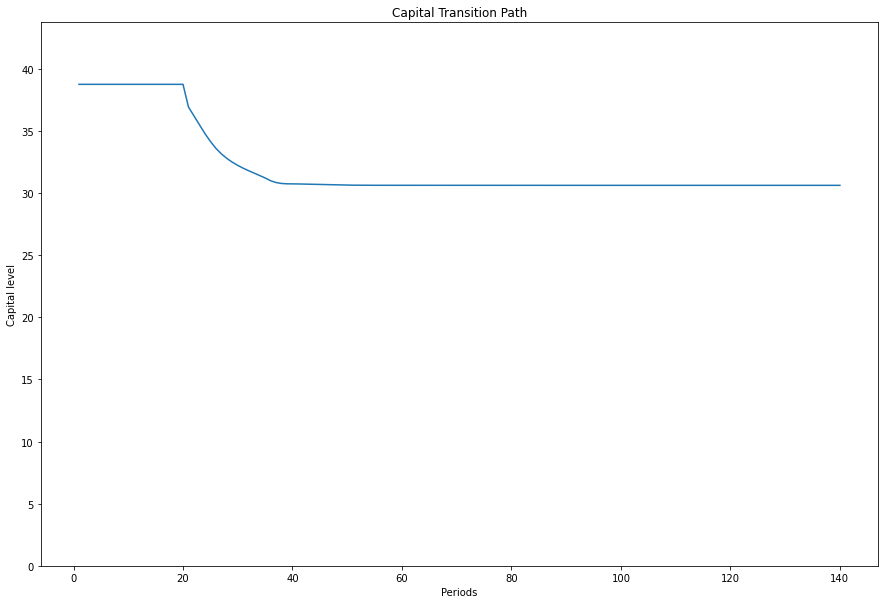

In [14]:
# Timing of events
T_shock      = T     # Time of the shock
T_conv       = 100   # Convergence periods (T_conv>T to allow for extra time to convergence after all shocked cohorts die off)
T_perfect    = T     # Perfect foresight periods (People foresee SS prices T periods into the future when making choices)

# The full timeline
TP = T_shock + T_conv + T_perfect

# In period T_shock, the contribution rate is unexpectedly changed from 0 to 0.1
τ0 = 0.0
τ1 = 0.1

## calculate pre-MIT-shock K_ss
K_ss0 = SS.Kss(τ0,par)

## calculate post-MIT-shock K_ss
K_ss1 = SS.Kss(τ1,par)


##########
# Step 1: Guess a transition path of captial

# Interpolating guess for K
Kvec = np.concatenate([np.repeat(K_ss0,T_shock),np.linspace(K_ss0,K_ss1,T_conv),np.repeat(K_ss1,T_perfect)])

##########
# Step 2: Compute associated factor prices and pension beneftis
rvec = α*(Kvec/L)**(α-1) - δ
wvec = (1 - α)*(Kvec/L)**α
τvec = np.concatenate([np.repeat(τ0,T_shock),np.repeat(τ1,T_conv+T_perfect)])
bvec = τvec*wvec*sum(l)/(T-R)

# Preallocating
A = np.zeros([TP,T])
C = np.zeros([TP,T])

# Computing steady-state savings and consumption in the old steady state
A_pre,C_pre = savings_function(np.repeat(rvec[0],T),np.repeat(wvec[0],T),np.repeat(bvec[0],T),τ0,par)

# Pre-shock consumption-saving paths (updated later)
for tp in range(T_shock):
        A[tp,:] = A_pre
        C[tp,:] = C_pre
        
# Iterating over guesses of the capital transition path until convergence of the entire path
stepsize = 100000000 # Initially a large number that should converge to zero 
tol = 0.000001
counter = 0


while stepsize>tol: # keep updating the captial transition path until convergence 
    counter = counter + 1 # Count iterations until convergence
    ktemp   = np.copy(Kvec)        # Save current guess of the transition path
    
    ##########
    # Step 3:
    # Adjusting consumption-saving paths for people aged 1 to T at the time of the shock (reacting to changes in 
    # prices and policy)
    for age in range(T):
        A[tp-age,:],C[tp-age,:] = update_savings(age,np.copy(A_pre),np.copy(C_pre),rvec[(tp-age):(tp+T-age)],wvec[(tp-age):(tp+T-age)],bvec[(tp-age):(tp+T-age)],τ0,par)
   
    ##########
    # Step 4: Loop over period after the shock
    # Giving birth to new cohorts (born after the shock) and writing forward capital, factor prices, and benefits
    for tp in range(T_shock,T_shock + T_conv,1):
        ##########
        # Step 4 A: 
        # use inherited savings to produce a new guess for capital, factor prices and pennsion benefits in the given period.
        Kvec[tp] = sum(np.diag(np.flipud(A[(tp-T):tp,:])))
        rvec[tp] = α*(Kvec[tp]/L)**(α-1) - δ
        wvec[tp] = (1 - α)*(Kvec[tp]/L)**α
        bvec[tp] = τvec[tp]*wvec[tp]*sum(l)/(T-R)
        
        ##########
        # Step 4 B: for cohorts born after the shock, compute new consumption and savings decisions given future prices.
        A[tp,:],C[tp,:] = savings_function(rvec[tp:(tp+T)],wvec[tp:(tp+T)],bvec[tp:(tp+T)],τ1,par)
    
    
    # Update stepsize
    if counter>0:
        stepsize = max(abs(Kvec-ktemp))

print('Number of itrations until convergence: ',counter)

# Plot capital transition path
plt.plot(np.linspace(1,TP,TP),Kvec)
plt.ylim(0, max(Kvec)+5)
plt.title('Capital Transition Path')
plt.xlabel("Periods")
plt.ylabel("Capital level")
plt.show()
